In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.neural_network import MLPRegressor 

#visualisation
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/allstate-claims-severity/train.csv
/kaggle/input/allstate-claims-severity/sample_submission.csv
/kaggle/input/allstate-claims-severity/test.csv


In [2]:
#Step 1: Load  data

train_data = pd.read_csv('../input/allstate-claims-severity/train.csv')
test_data = pd.read_csv('../input/allstate-claims-severity/test.csv')
print ("Finished reading train and test data...")

Finished reading train and test data...


#of columns in train data:  133
#of columns in test data:  133


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


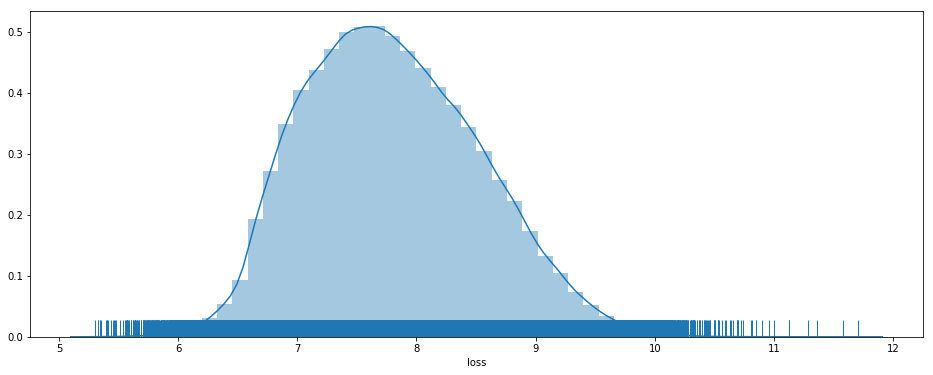

In [3]:

#step 2: Normalization & preprocessing
#To do one-hot-encoding, we need to concatenate data sets, see
#https://medium.com/@vaibhavshukla182/how-to-solve-mismatch-in-train-and-test-set-after-categorical-encoding-8320ed03552f

#add train column 
train_data['train'] = 1
test_data ['train'] = 0
test_data['loss'] = 0.0

#change distribution of the loss - as it is very scewed
# Set the width and height of the figure
plt.figure(figsize=(16,6))
train_data['loss'] = np.log(train_data['loss']+200)
sns.distplot(train_data['loss'], hist = True, rug = True)



print ("#of columns in train data: ", train_data.columns.size)
print ("#of columns in test data: ", test_data.columns.size)

#combine datasets
combined_data = pd.concat([train_data, test_data])

#normalize numerical data (subtract mean & divide by st.dev.)
numerical_data = combined_data.select_dtypes(include = "float64").filter(like='cont')

#convert categorical and object data using one-hot-encoding
categorical_data = combined_data.select_dtypes(include=["object", "category"])
ohe_categorical_data = pd.get_dummies (categorical_data)


#concatenate id, numerical, ohe-encoded catetogires, loss and train indicator
combined_data = pd.concat([combined_data['id'],ohe_categorical_data, numerical_data, combined_data['loss'], combined_data['train']], axis = 1)

#extract train data
train_data = combined_data[combined_data['train'] == 1]
train_data.drop(['train'], axis = 1, inplace = True)
#exctract test data and delete columns
test_data = combined_data[combined_data['train'] == 0]
test_data.drop(['train'], axis = 1, inplace = True)
test_data.drop(['loss'], axis = 1, inplace = True)

#print ("===Train data===")
#print ("#columns: {}".format(train_data.columns.size))
#print (train_data.head())
#print ("===Test data===")
#print ("#columns: {}".format(test_data.columns.size))
#print (test_data.head())


In [4]:

#Step 2: Build and train neural net using scikit MLPRegressor lib
X_train = train_data.drop(['id', 'loss'], axis = 1)
y_train = train_data["loss"]

print ("Building and training neural network on {} data points...".format(len(train_data)))
claimNet= MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=True, epsilon=1e-08,
             hidden_layer_sizes=(1500,1500,1500), learning_rate='constant',
             learning_rate_init=0.001, max_iter=500, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=True, warm_start=False)

claimNet.fit(X_train,y_train)
print ("Finished training...")

Building and training neural network on 188318 data points...
Iteration 1, loss = 0.49093615
Validation score: 0.533569
Iteration 2, loss = 0.12592463
Validation score: 0.538944
Iteration 3, loss = 0.12424171
Validation score: 0.542992
Iteration 4, loss = 0.12504981
Validation score: 0.548062
Iteration 5, loss = 0.11901875
Validation score: 0.515467
Iteration 6, loss = 0.11726270
Validation score: 0.524879
Iteration 7, loss = 0.11455938
Validation score: 0.476238
Iteration 8, loss = 0.11421732
Validation score: 0.539513
Iteration 9, loss = 0.11006361
Validation score: 0.531170
Iteration 10, loss = 0.11084009
Validation score: 0.541850
Iteration 11, loss = 0.10679152
Validation score: 0.540823
Iteration 12, loss = 0.10511907
Validation score: 0.530807
Iteration 13, loss = 0.10421881
Validation score: 0.476047
Iteration 14, loss = 0.10129000
Validation score: 0.526269
Iteration 15, loss = 0.09894158
Validation score: 0.502175
Validation score did not improve more than tol=0.000100 for 10

In [5]:
print ("Loading test data...")
#load and transform test data


Loading test data...


Starting predictions on 125546 data points
Finished test and I/O to csv file


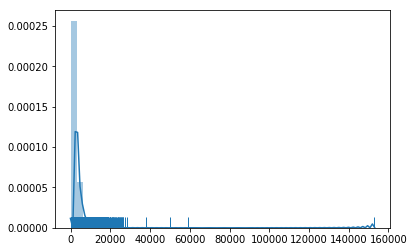

In [6]:
x_test = test_data.drop(['id'], axis = 1)
print ("Starting predictions on {} data points".format(len(x_test)))
predictions = claimNet.predict(x_test) 
output = pd.DataFrame({'id': test_data.id,'loss': np.exp(predictions)-200})

sns.distplot(np.exp(predictions)-200, hist = True, rug = True)

output.to_csv('submission.csv', index=False)
print("Finished test and I/O to csv file")